# This program uses Long Short Term Memory to predict the closing stock price. The prediction is based on the past 60 days stock price.

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt


In [ ]:
# Get the stock quote
crypto_currency = 'BTC'  # BTC
against_currency = 'EUR'
data_source ='yahoo'
period = 20

start = dt.datetime(2012, 1, 1)
end = dt.datetime.now() - dt.timedelta(period + 1)

ticket = f'{crypto_currency}-{against_currency}'

df = web.DataReader(ticket, data_source=data_source, start=start, end=end)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-17,9316.917969,9240.340820,9253.401367,9246.486328,1.466026e+10,9246.486328
2019-09-18,9319.454102,8917.574219,9248.524414,9292.973633,1.804724e+10,9292.973633
2019-09-19,9334.069336,9194.604492,9292.886719,9239.483398,1.337076e+10,9239.483398
2019-09-20,9245.341797,9075.292969,9241.304688,9092.541992,1.218296e+10,9092.541992
2019-09-21,9142.628906,9004.768555,9096.534180,9138.951172,1.197878e+10,9138.951172


In [ ]:
df.reset_index(inplace = True)
df.set_index(["Date"])
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-09-17,9316.917969,9240.340820,9253.401367,9246.486328,1.466026e+10,9246.486328
1,2019-09-18,9319.454102,8917.574219,9248.524414,9292.973633,1.804724e+10,9292.973633
2,2019-09-19,9334.069336,9194.604492,9292.886719,9239.483398,1.337076e+10,9239.483398
3,2019-09-20,9245.341797,9075.292969,9241.304688,9092.541992,1.218296e+10,9092.541992
4,2019-09-21,9142.628906,9004.768555,9096.534180,9138.951172,1.197878e+10,9138.951172


In [ ]:
sma = df['Close'].rolling(window=period).mean()  # Simple moving average (SMA)
std = df['Close'].rolling(window=period).std()  # Standard deviation
df['Upper'] = sma + (std *2)  # Bollinger band
df['Lower'] = sma - (std *2)  # Bollinger band

df['Short'] = df.Close.ewm(span=20, adjust=False).mean()  # Exponential moving average
df['Long'] = df.Close.ewm(span=50, adjust=False).mean()  # Exponential moving average

df['20MA'] = df['Close'].rolling(window=20).mean()  # 20 moving average (20MA)
df['50MA'] = df['Close'].rolling(window=50).mean()  # 50 moving average (50MA)

shortema = df.Close.ewm(span=12, adjust=False).mean()  # Exponential moving average
longema = df.Close.ewm(span=26, adjust=False).mean()  # Exponential moving average
df['MACD'] = shortema - longema  # MACD
df['Signal'] = df.MACD.ewm(span=9, adjust=False).mean()  # Exponential moving average

df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Upper,Lower,Short,Long,20MA,50MA,MACD,Signal
0,2019-09-17,9316.917969,9240.340820,9253.401367,9246.486328,1.466026e+10,9246.486328,NaN,NaN,9246.486328,9246.486328,NaN,NaN,0.000000,0.000000
1,2019-09-18,9319.454102,8917.574219,9248.524414,9292.973633,1.804724e+10,9292.973633,NaN,NaN,9250.913690,9248.309360,NaN,NaN,3.708389,0.741678
2,2019-09-19,9334.069336,9194.604492,9292.886719,9239.483398,1.337076e+10,9239.483398,NaN,NaN,9249.825091,9247.963244,NaN,NaN,2.304534,1.054249
3,2019-09-20,9245.341797,9075.292969,9241.304688,9092.541992,1.218296e+10,9092.541992,NaN,NaN,9234.845748,9241.868293,NaN,NaN,-10.543437,-1.265288
4,2019-09-21,9142.628906,9004.768555,9096.534180,9138.951172,1.197878e+10,9138.951172,NaN,NaN,9225.712932,9237.832327,NaN,NaN,-16.787201,-4.369671


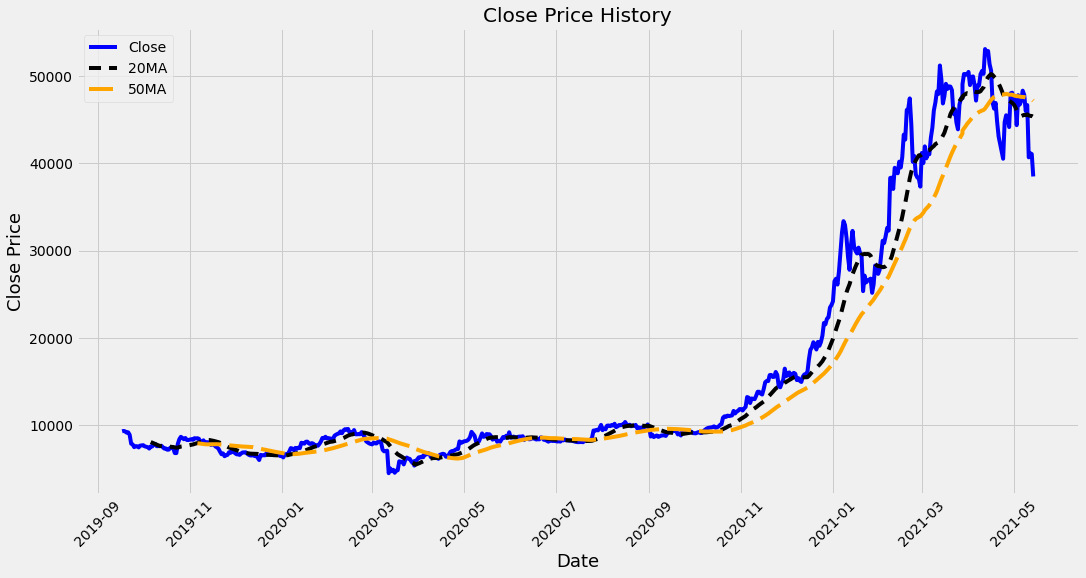

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.plot(df['Date'], df['20MA'], label='20MA', color='black', dashes=[3, 2])
plt.plot(df['Date'], df['50MA'], label='50MA', color='orange', dashes=[6, 2])
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation = 45)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

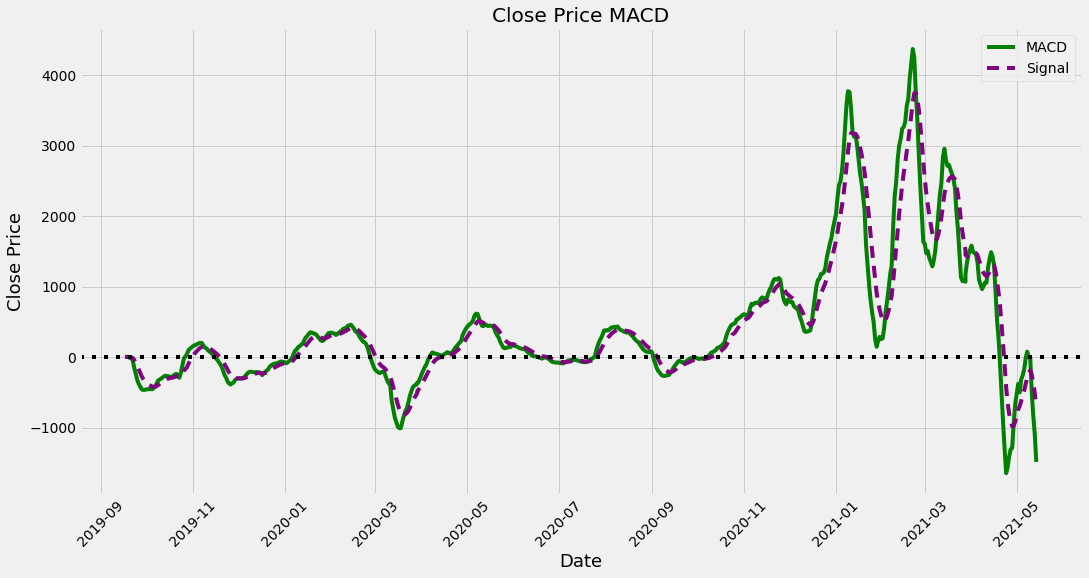

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
plt.title('Close Price MACD')
plt.plot(df['Date'], df['MACD'], label='MACD', color='green')
plt.plot(df['Date'], df['Signal'], label='Signal', color='purple', dashes=[3, 2])
plt.axhline(y = 0, color = 'black', dashes=[1, 2])
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation = 45)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

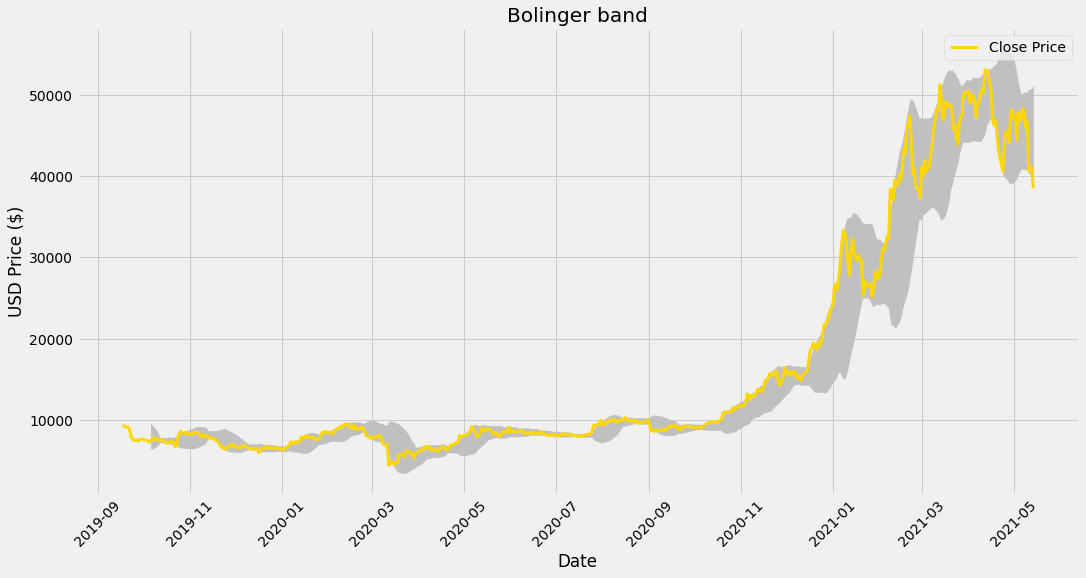

In [ ]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
x_axis = df['Date']
ax.fill_between(x_axis, df['Upper'], df['Lower'], color='silver')
ax.plot(x_axis, df['Close'], color='gold', lw=3, label='Close Price')
ax.set_title('Bolinger band')
ax.set_xlabel('Date')
ax.set_ylabel('USD Price ($)')
plt.xticks(rotation = 45)
ax.legend()
plt.show()


---

## **Model**


In [ ]:
# Filtering with Close Column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

482

In [ ]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# Creating Data set
train_data = scaled_data[0:training_data_len, :]
x_train, y_train = [], []

for i in range(period, len(train_data)):
  x_train.append(train_data[i-period:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((462, 20), (462,))

In [ ]:
# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(462, 20, 1)

In [ ]:
# Building the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=50))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)
# model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/10
462/462 [==============================] - 6s 7ms/step - loss: 0.0022
Epoch 2/10
462/462 [==============================] - 3s 7ms/step - loss: 6.2565e-04
Epoch 3/10
462/462 [==============================] - 3s 7ms/step - loss: 6.6078e-04
Epoch 4/10
462/462 [==============================] - 3s 8ms/step - loss: 9.3999e-04
Epoch 5/10
462/462 [==============================] - 3s 7ms/step - loss: 8.3540e-04
Epoch 6/10
462/462 [==============================] - 3s 8ms/step - loss: 7.0261e-04
Epoch 7/10
462/462 [==============================] - 3s 8ms/step - loss: 2.7156e-04
Epoch 8/10
462/462 [==============================] - 3s 7ms/step - loss: 4.5280e-04
Epoch 9/10
462/462 [==============================] - 3s 7ms/step - loss: 2.2578e-04
Epoch 10/10
462/462 [==============================] - 3s 7ms/step - loss: 7.5810e-04


In [ ]:
# Testing Data Set
test_data = scaled_data[training_data_len - period: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(period, len(test_data)):
  x_test.append(test_data[i-period:i, 0])

x_test = np.array(x_test)
x_test.shape

(120, 20)

In [ ]:
# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(120, 20, 1)

In [ ]:
# Test the model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

predictions.shape

(120, 1)

In [ ]:
# RMSE
# rmse = np.sqrt(np.mean((predictions - y_test)**2))
# rmse = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(predictions)), 2)))
rmse = np.sqrt(((predictions - y_test)**2).mean())
rmse

2338.211082546701

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


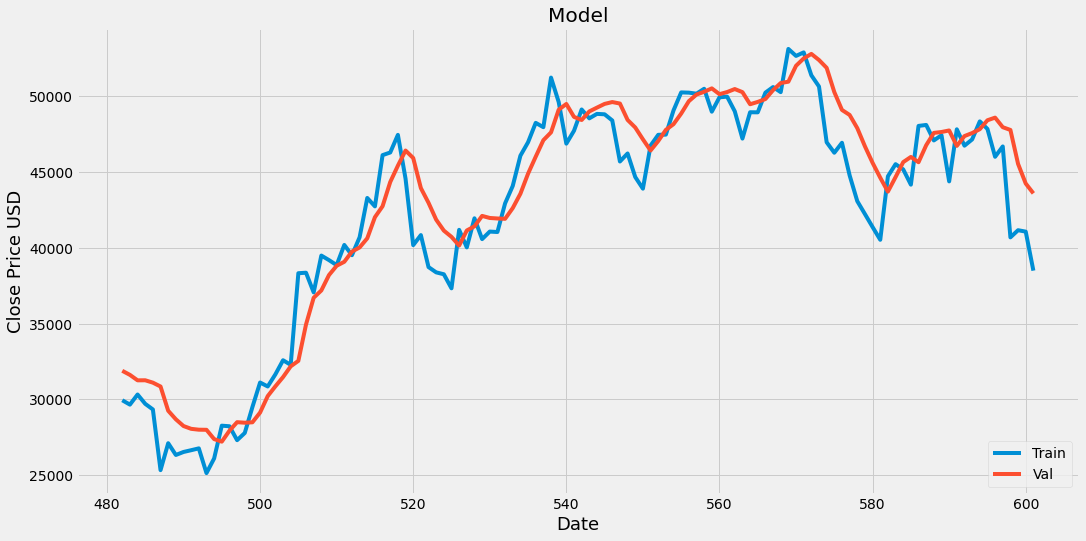

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
# plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Valid - Predicted
valid

,Close,Predictions
482,29950.035156,31893.628906
483,29661.734375,31623.689453
484,30328.933594,31263.640625
485,29713.658203,31267.556641
486,29342.677734,31110.546875
...,...,...
597,46692.531250,47961.671875
598,40695.511719,47780.289062
599,41166.695312,45540.699219
600,41072.777344,44246.863281


In [ ]:
# Predicted last know price
end = dt.datetime.now() - dt.timedelta(2)

df_predicted = web.DataReader(ticket, data_source=data_source, start=start, end=end)
new_df = df_predicted.filter(['Close'])
last_60_days = new_df[-period:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price[0][0]), 6)

print(f'Predicted price: ${pred_price}')

Predicted price: $31161.925781


In [ ]:
next = dt.datetime.now() - dt.timedelta(1)

df_real = web.DataReader(ticket, data_source=data_source, start=next, end=next)
real_price = df_real['Close'].values

real_price = round(float(real_price[0]), 6)
print(f'Real price: ${real_price}')

Real price: $32321.550781


In [ ]:
diff = (real_price - pred_price)
dffp = 100 * diff / real_price
print(f'Difference: ${round(diff,2)} {round(dffp,2)}%')

Difference: $1159.62 3.59%


In [ ]:
# Predicted last know price
end = dt.datetime.now()

df_predicted = web.DataReader(ticket, data_source=data_source, start=start, end=end)
new_df = df_predicted.filter(['Close'])
last_60_days = new_df[-period:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price[0][0]), 6)

print(f'Predicted price: ${pred_price}')

Predicted price: $31044.833984
